## FTP Connection

### Connection Parameters

In [1]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [2]:
# The topic of interest.
topic_dir = "/daily/more_precip/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [3]:
local_ftp_dir         = "F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [4]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/

F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/generated/DWD/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/generated/DWD//daily/more_precip/historical/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/generated/DWD//daily/more_precip/historical/
F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/generated/DWD//daily/more_precip/his

In [5]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [6]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [7]:
ret = ftp.cwd(".")

### FTP Grab File Function

In [8]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [9]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "station_name", "ext", "size", "type"])
    return(df_ftpdir)

In [10]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [11]:
df_ftpdir.head(10)

,station_id,station_name,ext,size,type
0,-1,BESCHREIBUNG_obsgermany_climate_daily_more_pre...,.pdf,72261,-
1,-1,DESCRIPTION_obsgermany_climate_daily_more_prec...,.pdf,71026,-
2,-1,RR_Tageswerte_Beschreibung_Stationen.txt,.txt,1202111,-
3,1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
4,2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-
5,3,tageswerte_RR_00003_18910101_20110331_hist.zip,.zip,162410,-
6,4,tageswerte_RR_00004_19510101_19791031_hist.zip,.zip,45468,-
7,6,tageswerte_RR_00006_19821101_20181231_hist.zip,.zip,38084,-
8,7,tageswerte_RR_00007_19510101_19960131_hist.zip,.zip,69540,-
9,8,tageswerte_RR_00008_19310101_19911231_hist.zip,.zip,88001,-


### Dataframe with TS Zip Files

In [12]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

,station_name,ext,size,type
station_id,,,,
1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-
3,tageswerte_RR_00003_18910101_20110331_hist.zip,.zip,162410,-
4,tageswerte_RR_00004_19510101_19791031_hist.zip,.zip,45468,-
6,tageswerte_RR_00006_19821101_20181231_hist.zip,.zip,38084,-
7,tageswerte_RR_00007_19510101_19960131_hist.zip,.zip,69540,-
8,tageswerte_RR_00008_19310101_19911231_hist.zip,.zip,88001,-
9,tageswerte_RR_00009_19920601_20101231_hist.zip,.zip,31560,-
10,tageswerte_RR_00010_19610101_20050831_hist.zip,.zip,66983,-


### Download the Station Description File

In [13]:
station_fname = df_ftpdir[df_ftpdir['station_name'].str.contains(station_desc_pattern)]["station_name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

RR_Tageswerte_Beschreibung_Stationen.txt


In [14]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt
To:   F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt


In [15]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'station_name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [16]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,station_name,state
station_id,,,,,,,
1,1912-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
2,1951-01-01,2006-12-31,138,50.8066,6.0996,Aachen (Kläranlage),Nordrhein-Westfalen
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
4,1951-01-01,1979-10-31,243,50.7683,6.1207,Aachen-Brand,Nordrhein-Westfalen
6,1982-11-01,2020-02-23,455,48.8361,10.0598,Aalen-Unterrombach,Baden-Württemberg


### Select Stations Located in/near Xanten from Station Description Dataframe

In [17]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    2,     3,     4,    38,    42,    79,    98,   104,   110,
              186,
            ...
            15456, 15559, 15919, 15927, 15963, 15980, 16087, 19042, 19043,
            19125],
           dtype='int64', name='station_id', length=500)

In [18]:
# Create variable with TRUE if area is Xanten or near Xanten
isNRW = df_stations['state'] == "Nordrhein-Westfalen"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

isBefore1950 = df_stations['date_from'] > '1930'

#Station near xanten
xanten_lat = df_stations[df_stations['station_name'].str.contains('Xanten')]['latitude'].iloc[0]
xanten_long = df_stations[df_stations['station_name'].str.contains('Xanten')]['longitude'].iloc[0]
nearXanten = (df_stations['latitude'] < xanten_lat + 0.2) & (df_stations['latitude'] > xanten_lat - 0.2) & (df_stations['longitude'] < xanten_long + 0.2) & (df_stations['longitude'] > xanten_long - 0.2)

#As there is no data found in these station
without14177 = df_stations.index != 14177 
without14175 = df_stations.index != 14175

# select on both conditions
dfNRW = df_stations[isNRW & nearXanten & isOperational & isBefore1950 & without14177 & without14175]
#print("Number of stations in/near Xanten: \n", dfNRW.count())
dfNRW

,date_from,date_to,altitude,latitude,longitude,station_name,state
station_id,,,,,,,
554,1946-01-01,2020-02-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
1999,1931-01-01,2020-02-27,23,51.7217,6.5839,Hamminkeln-Mühlenrott,Nordrhein-Westfalen
5502,1951-01-01,2020-02-27,25,51.6927,6.5853,Wesel-Flüren,Nordrhein-Westfalen
5733,1951-01-01,2020-02-27,20,51.6970,6.3974,Xanten,Nordrhein-Westfalen


In [19]:
df_zips.head()

,station_name,ext,size,type
station_id,,,,
1,tageswerte_RR_00001_19120101_19860630_hist.zip,.zip,109677,-
2,tageswerte_RR_00002_19510101_20061231_hist.zip,.zip,82951,-
3,tageswerte_RR_00003_18910101_20110331_hist.zip,.zip,162410,-
4,tageswerte_RR_00004_19510101_19791031_hist.zip,.zip,45468,-
6,tageswerte_RR_00006_19821101_20181231_hist.zip,.zip,38084,-


### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [20]:
list(dfNRW.index)

[554, 1999, 5502, 5733]

In [21]:
# Add the names of the zip files only to a list. 
local_zip_list = []

station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["station_name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

tageswerte_RR_00554_19460101_20181231_hist.zip
tageswerte_RR_01999_19310101_20181231_hist.zip
tageswerte_RR_05502_19510101_20181231_hist.zip
tageswerte_RR_05733_19510101_20181231_hist.zip


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [22]:
def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])
    
    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    
    df = df[((df.index >= "2016-05-01") & (df.index <= "2016-06-30")) | ((df.index >= "2017-05-01") & (df.index <= "2017-06-30") | (df.index >= "2018-05-01") & (df.index <= "2018-06-30"))]
    return(df)

In [23]:
from zipfile import ZipFile

In [24]:
def ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["rs"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [25]:
df_merged_ts = ts_merge()
# df_merged_ts = df_merged_ts2 = ts_merge()

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/tageswerte_RR_00554_19460101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19460101_20181231_00554.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/tageswerte_RR_01999_19310101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19310101_20181231_01999.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/tageswerte_RR_05502_19510101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20181231_05502.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/hist

In [26]:
df_merged_ts.head()

,554,1999,5502,5733
time,,,,
2016-05-01,0.0,0.0,0.0,0.0
2016-05-02,2.6,2.7,3.4,3.5
2016-05-03,0.0,0.0,0.0,0.0
2016-05-04,0.0,0.0,0.0,0.0
2016-05-05,0.0,0.0,0.0,0.0


## Filtering between May and June

In [27]:
if df_merged_ts.index.dtype != "int64":
    df_merged_ts.reset_index(level=0, inplace=True)

In [28]:
date_from = [pd.Timestamp(2016, 5, 1), pd.Timestamp(2017, 5, 1), pd.Timestamp(2018, 5, 1)]
date_to = [pd.Timestamp(2016, 6, 30), pd.Timestamp(2017, 6, 30), pd.Timestamp(2018, 6, 30)]

df_selectedRange = pd.DataFrame()

i = 0
while i < len(date_from):
    ifBetweenDate  = (df_merged_ts['time'] <= date_to[i]) & (df_merged_ts['time'] >= date_from[i])
    dFrame = df_merged_ts[ifBetweenDate]
    dFrame = pd.concat([dFrame['time'], dFrame.iloc[:,1:].cumsum(axis=0)], axis=1)
    df_selectedRange = df_selectedRange.append(dFrame)
    i += 1
    
df_selectedRange.to_csv(local_ts_merged_dir + "cumulative_precipitation.csv", index=False, sep=";")
df_selectedRange.head()

,time,554,1999,5502,5733
0,2016-05-01,0.0,0.0,0.0,0.0
1,2016-05-02,2.6,2.7,3.4,3.5
2,2016-05-03,2.6,2.7,3.4,3.5
3,2016-05-04,2.6,2.7,3.4,3.5
4,2016-05-05,2.6,2.7,3.4,3.5


In [93]:
date_from = pd.Timestamp(2016, 5, 1)
date_to = pd.Timestamp(2016, 6, 30)

df_selectedRange_2016 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame.iloc[:,1:].cumsum(axis=0)], axis=1)
df_selectedRange_2016 = df_selectedRange_2016.append(dataFrame)

date_from = pd.Timestamp(2017, 5, 1)
date_to = pd.Timestamp(2017, 6, 30)

df_selectedRange_2017 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame.iloc[:,1:].cumsum(axis=0)], axis=1)
df_selectedRange_2017 = df_selectedRange_2017.append(dataFrame)

date_from = pd.Timestamp(2018, 5, 1)
date_to = pd.Timestamp(2018, 6, 30)

df_selectedRange_2018 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame.iloc[:,1:].cumsum(axis=0)], axis=1)
df_selectedRange_2018 = df_selectedRange_2018.append(dataFrame)



# df_selectedRange_2016

## Ploting the data

In [30]:
%matplotlib inline

In [31]:
import matplotlib.pyplot as plt
import numpy as np

In [91]:
date_from = pd.Timestamp(2016, 5, 1)
date_to = pd.Timestamp(2016, 6, 30)

df_Range_2016 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame[554], dataFrame[1999], dataFrame[5502], dataFrame[5733]], axis=1)
df_Range_2016 = df_Range_2016.append(dataFrame)

date_from = pd.Timestamp(2017, 5, 1)
date_to = pd.Timestamp(2017, 6, 30)

df_Range_2017 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame[554], dataFrame[1999], dataFrame[5502], dataFrame[5733]], axis=1)
df_Range_2017 = df_Range_2017.append(dataFrame)

date_from = pd.Timestamp(2018, 5, 1)
date_to = pd.Timestamp(2018, 6, 30)

df_Range_2018 = pd.DataFrame()

ifBetweenDate  = (df_merged_ts['time'] <= date_to) & (df_merged_ts['time'] >= date_from)
dataFrame = df_merged_ts[ifBetweenDate]
dataFrame = pd.concat([dataFrame['time'], dataFrame[554], dataFrame[1999], dataFrame[5502], dataFrame[5733]], axis=1)
df_Range_2018 = df_Range_2018.append(dataFrame)

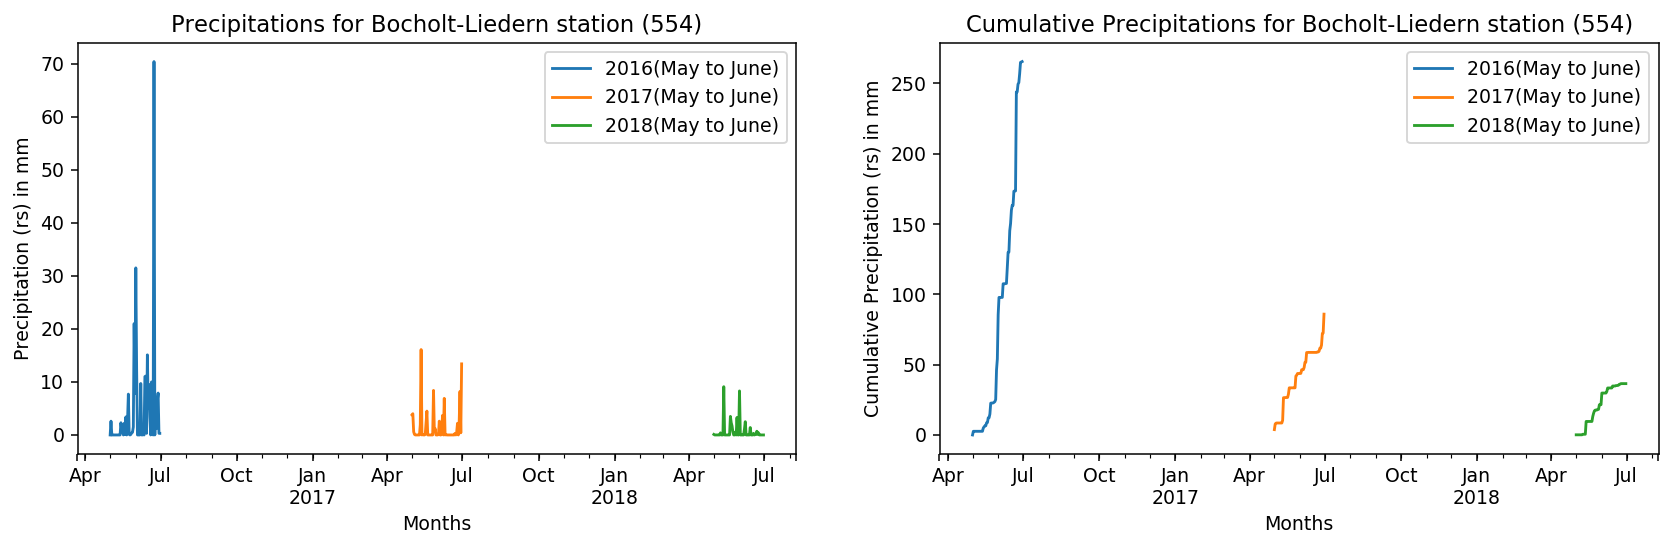

In [92]:
fig = plt.figure(dpi= 136, figsize=(15,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_Range_2016.plot(ax=ax1, x='time', y=554, label='2016(May to June)') 
df_Range_2017.plot(ax=ax1, x='time', y=554, label='2017(May to June)')
df_Range_2018.plot(ax=ax1, x='time', y=554, label='2018(May to June)',)
ax1.set_title('Precipitations for Bocholt-Liedern station (554)')
ax1.set_xlabel('Months')
ax1.set_ylabel('Precipitation (rs) in mm')

df_selectedRange_2016.plot(ax=ax2, x='time', y=554, label='2016(May to June)') 
df_selectedRange_2017.plot(ax=ax2, x='time', y=554, label='2017(May to June)')
df_selectedRange_2018.plot(ax=ax2, x='time', y=554, label='2018(May to June)',)
ax2.set_title('Cumulative Precipitations for Bocholt-Liedern station (554)')
ax2.set_xlabel('Months')
ax2.set_ylabel('Cumulative Precipitation (rs) in mm')

legend = ax.legend(loc = 'upper right')

plt.show()

In [33]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

In [34]:
df_merged_ts_transposed = df_merged_ts.transpose()

In [35]:
df_merged_ts_transposed.index.names = ['station_id']

In [36]:
df_merged_ts_transposed.head()

,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
station_id,,,,,,,,,,,,,,,,,,,,,
time,2016-05-01 00:00:00,2016-05-02 00:00:00,2016-05-03 00:00:00,2016-05-04 00:00:00,2016-05-05 00:00:00,2016-05-06 00:00:00,2016-05-07 00:00:00,2016-05-08 00:00:00,2016-05-09 00:00:00,2016-05-10 00:00:00,...,2018-06-21 00:00:00,2018-06-22 00:00:00,2018-06-23 00:00:00,2018-06-24 00:00:00,2018-06-25 00:00:00,2018-06-26 00:00:00,2018-06-27 00:00:00,2018-06-28 00:00:00,2018-06-29 00:00:00,2018-06-30 00:00:00
554,0,2.6,0,0,0,0,0,0,0,0,...,0.1,0.7,0.1,0.4,0,0,0,0,0,0
1999,0,2.7,0,0,0,0,0,0,0,1.4,...,0.3,0.5,0,0.2,0,0,0,0,0,0
5502,0,3.4,0,0,0,0,0,0,0,0.7,...,0.1,0.2,0,0.2,0,0,0,0,0,0
5733,0,3.5,0,0,0,0,0,0,0,0,...,0.2,2.2,0.5,0.3,0,0,0,0,0,0


In [37]:
df_merged_ts_transposed.to_csv(local_ts_merged_dir + "ts_merged_transposed.csv",sep=";")

## Finalized data by appending

In [38]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                #dftmp = temp_ts_to_df(myfile)
                dftmp = prec_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                 print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [39]:
df_appended_ts = ts_append()

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/tageswerte_RR_00554_19460101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19460101_20181231_00554.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/tageswerte_RR_01999_19310101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19310101_20181231_01999.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/historical/tageswerte_RR_05502_19510101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19510101_20181231_05502.txt

Zip archive: F:/Masters/Semester2/GeoInfo/asessment/MIE_2.02_GeoInfo_WS2019/gi0000_Final_Assignment/data/precipitation_2/original/DWD//daily/more_precip/hist

In [40]:
df_appended_ts.head()

,stations_id,qn_6,rs,rsf,sh_tag,nsh_tag,eor,date_from,date_to,altitude,latitude,longitude,station_name,state
mess_datum,,,,,,,,,,,,,,
2016-05-01,554,9,0.0,0.0,NaN,NaN,eor,1946-01-01,2020-02-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
2016-05-02,554,9,2.6,4.0,NaN,NaN,eor,1946-01-01,2020-02-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
2016-05-03,554,9,0.0,0.0,NaN,NaN,eor,1946-01-01,2020-02-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
2016-05-04,554,9,0.0,0.0,NaN,NaN,eor,1946-01-01,2020-02-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen
2016-05-05,554,9,0.0,0.0,NaN,NaN,eor,1946-01-01,2020-02-27,23,51.8293,6.5365,Bocholt-Liedern (Wasserwerk),Nordrhein-Westfalen


In [41]:
df_appended_ts.to_csv(local_ts_appended_dir + "ts_appended.csv",sep=";")